In [12]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import timeit
import time

<h1>Load training, validation, testing set from your preprocessed files</h1>

In [15]:
for i in range(5):
    with open('dogs-vs-cats-train-image-'+str(i)+'.pickle', 'rb') as f1:
        tmp = pickle.load(f1)
        try:
            train_image = np.concatenate((train_image, tmp))
        except:
            train_image = tmp
    with open('dogs-vs-cats-train-label-'+str(i)+'.pickle', 'rb') as f2:
        tmp = pickle.load(f2)
        try:
            train_label = np.concatenate((train_label, tmp))
        except:
            train_label = tmp
with open('dogs-vs-cats-val-image.pickle', 'rb') as f1:
    val_image = pickle.load(f1)
with open('dogs-vs-cats-val-label.pickle', 'rb') as f2:
    val_label = pickle.load(f2)
for i in range(3):
    with open('dogs-vs-cats-test-image-'+str(i)+'.pickle', 'rb') as ft:
        tmp = pickle.load(ft)
        try:
            test_image = np.concatenate((test_image, tmp))
        except:
            test_image = tmp
print(train_image.shape)
print(val_image.shape)
print(test_image.shape)
print(train_label.shape)
print(val_label.shape)

(98000, 227, 227, 3)
(500, 227, 227, 3)
(37500, 227, 227, 3)
(98000, 2)
(500, 2)


<h1>Define hyperparameter</h1>

In [24]:
lr = 0.0001
epochs = 10
batch_size = 128
dropout = 0.5
num_classes = 2
W = 227
H = 227
channel = 3

<h1>Placeholder</h1>

In [25]:
tf.reset_default_graph()
input_X = tf.placeholder(tf.float32,[None, W, H, channel], name='input_X')
input_Y = tf.placeholder(tf.int32,[None, num_classes], name='input_Y')
training = tf.placeholder_with_default(False, shape=())

<h1>AlexNet</h1>

In [26]:
def AlexNet(x):
    conv1_out = tf.layers.conv2d(x, 96, 11, 4, 'valid', activation=tf.nn.relu)
    maxPool1_out = tf.contrib.layers.max_pool2d(conv1_out, 3, 2, 'VALID')
    out1 = tf.nn.lrn(maxPool1_out)
    
    conv2_out = tf.layers.conv2d(out1, 256, 5, 1, 'same', activation=tf.nn.relu)
    maxPool2_out = tf.contrib.layers.max_pool2d(conv2_out, 3, 2, 'VALID')
    out2 = tf.nn.lrn(maxPool2_out)

    out3 = tf.layers.conv2d(out2, 384, 3, 1, 'same', activation=tf.nn.relu)
    
    out4 = tf.layers.conv2d(out3, 384, 3, 1, 'same', activation=tf.nn.relu)
    
    out5 = tf.layers.conv2d(out4, 256, 3, 1, 'same', activation=tf.nn.relu)    
    maxPool5_out = tf.contrib.layers.max_pool2d(out5, 3, 2, 'VALID')
    
    ly5_drop = tf.layers.dropout(maxPool5_out, dropout,  training=training)
    ly5_reshape = tf.reshape(ly5_drop, shape=[-1, 256 * 6 * 6])
    fc1 = tf.layers.dense(ly5_reshape, 512, activation=tf.nn.relu, use_bias=True)
    fc1_drop = tf.layers.dropout(fc1, dropout,  training=training)
    fc2 =  tf.layers.dense(fc1, 512, activation=tf.nn.relu, use_bias=True)
    logits = tf.layers.dense(fc2, 2, activation=tf.nn.softmax, use_bias=True)
    
    return logits

<h1>Cost and Optimization</h1>

In [28]:
logits = AlexNet(input_X)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=input_Y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(input_Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

<h1>Training and validation</h1>
<h2>Train your model only 10 epochs</h2>
<p style="font-size:20px">1. Print out training accuracy and validation accuracy each training epoch</p>
<p style="font-size:20px">2. Print out training time each training epoch</p>
<p style="font-size:20px">3. Your goal is to reach 85% validation accuracy in 10 training epochs. If you reach that, you can perform testing, print out your test accuracy. Plot out the ten images with title that contains the probability of the labeled class.</p>

In [29]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, data.shape[0])
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    data_shuffle = np.asarray(data_shuffle)
    labels_shuffle = np.asarray(labels_shuffle)
    labels_shuffle = np.squeeze(labels_shuffle)
    return data_shuffle, labels_shuffle

In [32]:
init = tf.global_variables_initializer()

total_batch = int(24500 / batch_size)

with tf.Session() as sess:
    sess.run(init)
    time_start = time.time()
    for i in range(epochs):
        for j in range(total_batch):
            batch_x, batch_y = next_batch(batch_size, train_image, train_label)
            sess.run(train_op, feed_dict={input_X:batch_x, input_Y:batch_y, training:True})
        time_end = time.time()
        l, acc = sess.run([loss, accuracy],feed_dict={input_X:batch_x, input_Y:batch_y})
        acc_val = sess.run(accuracy,feed_dict={input_X:val_image, input_Y:val_label})
        print("epoch " + str(i+1) + ", time: {:.3f}\t".format(time_end-time_start)+ ", loss: {:.4f}".format(l) + ", acc: {:.4f}".format(acc) + ", acc_val: {:.4f}".format(acc_val))
           
        time_start = time.time()
    pred_test = sess.run(logits, feed_dict = {input_X: test_image[:10]})

epoch 1, time: 27.659	, loss: 0.6351, acc: 0.5859, acc_val: 0.6740
epoch 2, time: 27.440	, loss: 0.5747, acc: 0.7188, acc_val: 0.7020
epoch 3, time: 27.268	, loss: 0.5104, acc: 0.7969, acc_val: 0.7540
epoch 4, time: 27.332	, loss: 0.5369, acc: 0.7812, acc_val: 0.7660
epoch 5, time: 27.462	, loss: 0.4626, acc: 0.8359, acc_val: 0.8340
epoch 6, time: 27.466	, loss: 0.5332, acc: 0.7812, acc_val: 0.8420
epoch 7, time: 27.203	, loss: 0.4443, acc: 0.8750, acc_val: 0.8700
epoch 8, time: 27.280	, loss: 0.4463, acc: 0.8594, acc_val: 0.8380
epoch 9, time: 27.329	, loss: 0.4025, acc: 0.9141, acc_val: 0.8640
epoch 10, time: 29.331	, loss: 0.4150, acc: 0.9062, acc_val: 0.8780


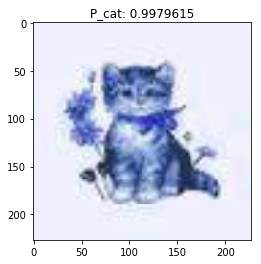

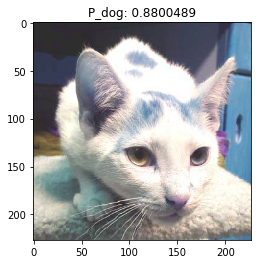

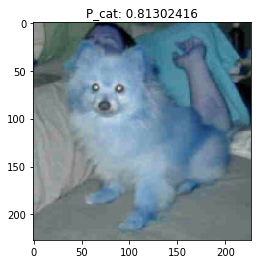

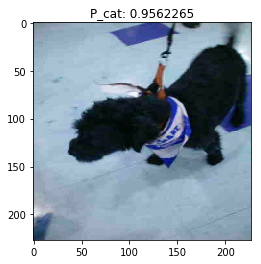

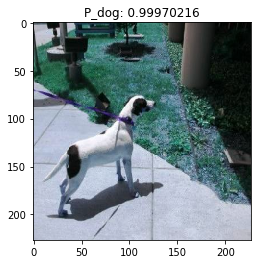

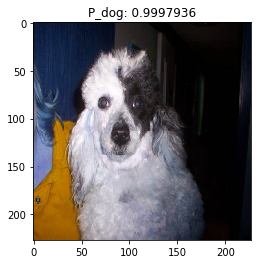

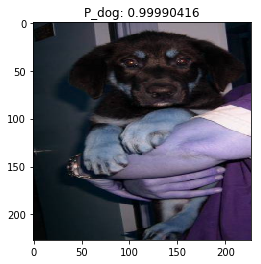

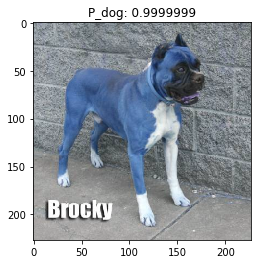

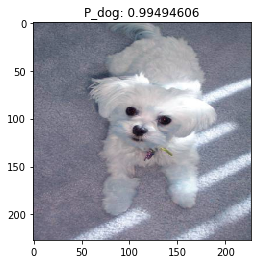

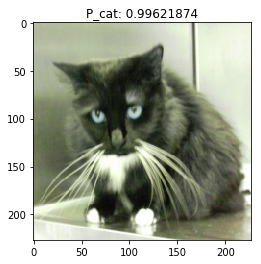

In [33]:
for i in range(10):
    pred = np.squeeze(pred_test[i])
    if pred[0] < pred[1]:
        result = "P_dog: "+str(pred[1])
    else:
        result = "P_cat: "+str(pred[0])
    fig = plt.figure()
    plt.imshow(np.squeeze(test_image[i]))
    plt.title(result)